In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

!pip install segmentation-models --quiet
!pip install git+https://github.com/HelioStrike/pathomics-research-utils.git

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.utils import Sequence
from keras.callbacks import Callback, ModelCheckpoint
import pathomics_research_utils as pru
from pathomics_research_utils import utils

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random
import segmentation_models as sm

# Any results you write to the current directory are saved as output.

  Cloning https://github.com/HelioStrike/pathomics-research-utils.git to /tmp/pip-req-build-pvws3jym
  Running command git clone -q https://github.com/HelioStrike/pathomics-research-utils.git /tmp/pip-req-build-pvws3jym
  Created wheel for pathomics-research-utils: filename=pathomics_research_utils-1.0-cp36-none-any.whl size=5561 sha256=770993ab64dd92ac0210cd134d640ecbe214d7b705ba62bba065ada03d0a5160
  Stored in directory: /tmp/pip-ephem-wheel-cache-wq7g2zx8/wheels/f7/fb/e1/5dea299a7509bb97fc9254d7489d6f4f167aa3a449daa3be93
Successfully built pathomics-research-utils


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [6]:
!wget http://andrewjanowczyk.com/wp-static/epi.tgz
!tar -zxvf epi.tgz
!mkdir epi
!mv *.tif epi
!mv masks epi
os.listdir('.')

--2020-01-15 06:41:47--  http://andrewjanowczyk.com/wp-static/epi.tgz
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352039805 (336M) [application/x-gzip]
Saving to: ‘epi.tgz’

epi.tgz             100%[===================>] 335.73M  4.86MB/s    in 72s     

2020-01-15 06:42:59 (4.67 MB/s) - ‘epi.tgz’ saved [352039805/352039805]

10254_00001.tif
10256_00003.tif
10257_00026.tif
10258_00006.tif
10259_00002.tif
10260_00022.tif
10261_00002.tif
10262_00025.tif
10264_00056.tif
10269_00022.tif
10273_00095.tif
10274_00004.tif
10275_00099.tif
10276_00037.tif
10277_00006.tif
10278_00006.tif
10279_00049.tif
10282_00016.tif
10285_00007.tif
10286_00014.tif
10288_00003.tif
10291_00012.tif
10292_00018.tif
10293_00011.tif
10295_00012.tif
10299_00154.tif
10301_00026.tif
10302_00098.tif
10303_00090.tif
10304_00005.tif
10306_00018.tif
10307_00

['.ipynb_checkpoints', '__notebook_source__.ipynb', 'epi.tgz', 'tubule', 'epi']

In [25]:
#Hyperparams
patch_height = 896
patch_width = 896
train_ratio = 0.8
initial_learning_rate = 0.0005

## Optimizer

## Vanilla UNet

In [8]:
def build_model(input_shape, output_channels=1):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

## Loss function

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [10]:
data_dir = 'epi'
fnames = os.listdir(data_dir)
mask_dir = 'epi/masks'
fnames += os.listdir(mask_dir)
fnames = sorted(fnames)
num_files = len(fnames)
paired_images_list = []

In [13]:
i = 0
while i < num_files-1:
    if(fnames[i][:-4] == fnames[i+1][:-9]):
        paired_images_list.append([os.path.join(data_dir,fnames[i]), os.path.join(data_dir,'masks/' + fnames[i+1])])
        i += 2
    else:
        i += 1

In [16]:
paired_images_list

[['epi/10260_00022.tif', 'epi/masks/10260_00022_mask.png'],
 ['epi/10261_00002.tif', 'epi/masks/10261_00002_mask.png'],
 ['epi/10264_00056.tif', 'epi/masks/10264_00056_mask.png'],
 ['epi/10278_00006.tif', 'epi/masks/10278_00006_mask.png'],
 ['epi/10279_00049.tif', 'epi/masks/10279_00049_mask.png'],
 ['epi/10282_00016.tif', 'epi/masks/10282_00016_mask.png'],
 ['epi/10285_00007.tif', 'epi/masks/10285_00007_mask.png'],
 ['epi/10286_00014.tif', 'epi/masks/10286_00014_mask.png'],
 ['epi/10288_00003.tif', 'epi/masks/10288_00003_mask.png'],
 ['epi/10291_00012.tif', 'epi/masks/10291_00012_mask.png'],
 ['epi/10293_00011.tif', 'epi/masks/10293_00011_mask.png'],
 ['epi/10295_00012.tif', 'epi/masks/10295_00012_mask.png'],
 ['epi/10302_00098.tif', 'epi/masks/10302_00098_mask.png'],
 ['epi/10304_00005.tif', 'epi/masks/10304_00005_mask.png'],
 ['epi/10308_00048.tif', 'epi/masks/10308_00048_mask.png'],
 ['epi/12626_00016.tif', 'epi/masks/12626_00016_mask.png'],
 ['epi/12818_00006.tif', 'epi/masks/1281

In [17]:
num_samples = len(paired_images_list)
num_train = int(0.8*num_samples)

In [26]:
class SubPatchingSegmentationDataGenerator(Sequence):
    def __init__(self, paired_images_list=None, patch_height=500, patch_width=500,
                 batch_size=8, shuffle=True, augmentation=None,
                 magnify=None, num_channels=3, output_channels=1):
        self.batch_size = batch_size
        self.patch_height = patch_height
        self.patch_width = patch_width
        self.num_channels = num_channels
        self.output_channels = output_channels
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.paired_images_list = paired_images_list
        self.len = int(len(self.paired_images_list) * (len(utils.get_image_subpatches(utils.read_image(paired_images_list[0][0])))**(0.5)-1)**2 // self.batch_size)
        self.shuffle = shuffle
        self.magnify = magnify
        self.image_ptr = 0
        self.cur = 0
        self.org_patches = []
        self.mask_patches = []

    def __len__(self):
        return (self.len-1)
    
    def on_epoch_start(self):
        self.image_ptr = 0
        self.cur = 0
        if self.shuffle:
            random.shuffle(self.paired_images_list)

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.patch_height, self.patch_width, self.num_channels))
        y = np.empty((self.batch_size, self.patch_height, self.patch_width, self.output_channels))
        for i in range(self.batch_size):
            if self.cur == len(self.org_patches):
                self.cur = 0
                if(self.image_ptr == len(self.paired_images_list)):
                    self.image_ptr = 0
                self.org_patches = utils.get_image_subpatches(utils.read_image(self.paired_images_list[self.image_ptr][0]), size=(self.patch_height, self.patch_width))
                self.mask_patches = utils.get_image_subpatches(utils.read_image(self.paired_images_list[self.image_ptr][1]), size=(self.patch_height, self.patch_width))
                self.mask_patches[np.where(self.mask_patches>0)] = 1
                self.image_ptr += 1

            dims = self.org_patches[self.cur].shape
            if(len(dims) == 2):
                X[i] = self.org_patches[self.cur].reshape(*dims, 1)
            else:
                X[i] = self.org_patches[self.cur]

            dims = self.mask_patches[self.cur].shape
            if(len(dims) == 2):
                y[i] = self.mask_patches[self.cur].reshape(*dims, 1)
            else:
                y[i] = self.mask_patches[self.cur]

            if self.augmentation:
                X[i] = self.augmentation(X[i])
                y[i] = self.augmentation(y[i])
            self.cur += 1
        return X, y

In [27]:
train_generator = SubPatchingSegmentationDataGenerator(paired_images_list=paired_images_list[:num_train-1], patch_height=patch_height, patch_width=patch_width)
val_generator = SubPatchingSegmentationDataGenerator(paired_images_list=paired_images_list[num_train:], patch_height=patch_height, patch_width=patch_width)

In [28]:
model = build_model((patch_height,patch_width,3))

In [29]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
#    val_generator,
    callbacks=[checkpoint],
    workers=1,
    epochs=7
)

Train for 3599 steps
Epoch 1/7
3599/3599 [==============================] - 1488s 413ms/step - loss: 0.4408 - dice_coef: 0.8656
Epoch 2/7
3599/3599 [==============================] - 1470s 408ms/step - loss: 0.0487 - dice_coef: 0.9795
Epoch 3/7
3599/3599 [==============================] - 1465s 407ms/step - loss: 0.0310 - dice_coef: 0.9869
Epoch 4/7
 369/3599 [==>...........................] - ETA: 21:51 - loss: 0.0193 - dice_coef: 0.9917

KeyboardInterrupt: 

In [30]:
def cleanPred(pred, threshold=0.5):
    pred[np.where(pred<=threshold)] = 0
    pred[np.where(pred>threshold)] = 1
    return pred

In [31]:
def compareMaskAndPreds(orig, mask):
    pred = model.predict(np.array([orig])).reshape(patch_height, patch_width)
    pred = cleanPred(pred)
    mask = mask.reshape(patch_height,patch_width)
    utils.displayImagesSideBySide([orig,mask,pred], titles=['Original', 'Mask', 'Predicted'])

In [32]:
orig = utils.get_image_subpatches(utils.read_image(paired_images_list[0][0]), size=(patch_height, patch_width))[0]
mask = utils.get_image_subpatches(utils.read_image(paired_images_list[0][1]), size=(patch_height, patch_width))[0]

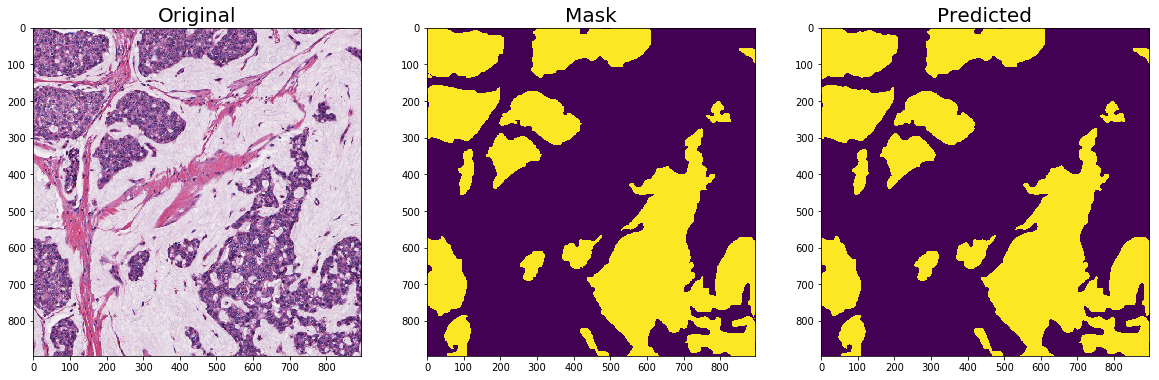

In [33]:
compareMaskAndPreds(orig, mask)

In [37]:
def showSomeResults(num):
    for i in range(num):
        ri = random.randint(num_train, num_samples-1)
        orig = utils.get_image_subpatches(utils.read_image(paired_images_list[ri][0]), size=(patch_height, patch_width))
        mask = utils.get_image_subpatches(utils.read_image(paired_images_list[ri][1]), size=(patch_height, patch_width))
        rpi = random.randint(0, len(orig)-1)
        orig = orig[rpi]
        mask = mask[rpi]
        compareMaskAndPreds(orig, mask)

In [38]:
showSomeResults(4)

NameError: name 'train_num' is not defined